# Comparing test sample classifications between models

This notebook addresses issue #9. We have compared the performance of various binary classifiers based on their prediction probabilities. Prediction probability is an interesting aspect to compare because it gives us an idea about the confidence of the clasiifier.

I would also like to mention that many aspect sof this issue has been taken care of in the startup task PR, like voting classifier, h-param tuning, etc.

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import time

import sklearn
from sklearn.metrics import accuracy_score
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# The kernel need not be refreshed if a custom helper file (included in the next cell) is updated
%load_ext autoreload
%autoreload 2
%matplotlib inline
matplotlib.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

## Import the custom helper files

In [2]:
from algorithm_helpers import *
from visualisation_helpers import *

In [3]:
# Optional
import warnings
warnings.filterwarnings('ignore')  # Logistic regression does not converge and the warnings are pretty long

# Load and display the dataset

In [4]:
path = '../../datasets/vehicles.csv' # path to dataset
df = pd.read_csv(path)

In [5]:
df.head()

,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO,Class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus


# Spliting the data into training and test set

The training set is a random selection of 80% of the original data. The testing set is the remaining 20%.

In [6]:
X = df.drop(labels='Class', axis=1) # drop the target attribute from the X variable
X = (X - X.mean())/X.std() # Normalize the data (though this is not the correct manner)
y = df.Class  # The target attribute to be predicted
train_X, test_X, train_y, test_y = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Classifiers

Why we have used the following classifiers?
1. Logistic Regression:  Logistic Regression performs well when the dataset is linearly separable and is less prone to overfitting
2. Gaussian Naive Bayes: Easy to implement and Fast. Also, It can make probabilistic predictions.
3. Linear SVC: It gives more flexibility in the choice of penalties and loss functions and it scales better to large numbers of samples.
4. Random Forest Classifier: It reduces overfitting due to its ensembling nature and is therefore more accurate than decision tree.

We have used only four classsifiers but all are of different types. This is done to study the behaviour of prediction probability of various classifiers.  

In [7]:
lr = linear_model.LogisticRegression()
gnb = naive_bayes.GaussianNB()
svc = svm.LinearSVC(C=1.0)
rfc = ensemble.RandomForestClassifier()

## Different Classes of the dataset

Let us now examine how various classes are distributed.

In [8]:
df.Class.value_counts()

bus     218
saab    217
opel    212
van     199
Name: Class, dtype: int64

Here, we observe that the classes are evenly distributed. The study of this variable is done because the goal is to perform binary classification on a multi class data, which would be meanigful only if the distribution of classes is even.

## Compare Function

Our dataset has 4 unique classes but we want to compare different binary classifiers therefore we take one of the classes as 1 and the remaining 3 classes as zero so that we can perform binary classificaton on it. We use 4 different classifiers mentioned above and compare their prediction probability.

This function takes an argument "Vehicle_type" that is the name of the vehicle. For example vehicle_type = "van"

In [9]:
def compare_alg(vehicle_type):
    df.NewClass = (df.Class == vehicle_type)*1
    y = df.NewClass  # The target attribute to be predicted
    # Splitting into training and test set
    train_X, test_X, train_y, test_y = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    plt.figure(figsize=(10, 10))
    print('Total no of', vehicle_type, sum(df.Class == vehicle_type))
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
        clf.fit(train_X, train_y)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(test_X)[:, 1]
        else:  # Use decision function
            prob_pos = clf.decision_function(test_X)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        ax2.hist(prob_pos, range=(0, 1), bins=10, label= name,
             histtype="step", lw=2)
        y_pred = clf.predict(test_X)
        print('Acuracy with:', name, clf.score(test_X, test_y))
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    plt.show()

## Class Van

Total no of van 199
Acuracy with: Logistic 0.9647058823529412
Acuracy with: Naive Bayes 0.6235294117647059
Acuracy with: Support Vector Classification 0.9529411764705882
Acuracy with: Random Forest 0.9764705882352941


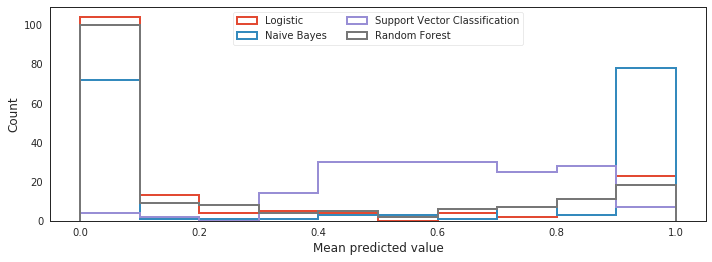

In [10]:
compare_alg("van")

Logistic Regression and Random Forest have high accuracy. The prediction probability of almost 100 cases for LR lie between 0 and 0.1 which shows that the classifier is quite inconfident. We also observe that SVC doesn't have very strong predictions as most of its prediction probability lies between 0.4 and 0.9. 

## Class saab

Total no of saab 217
Acuracy with: Logistic 0.8235294117647058
Acuracy with: Naive Bayes 0.6941176470588235
Acuracy with: Support Vector Classification 0.8176470588235294
Acuracy with: Random Forest 0.7941176470588235


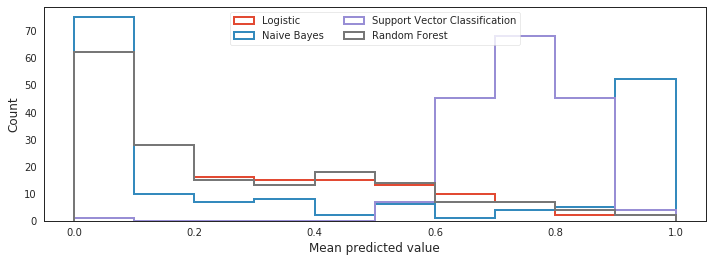

In [11]:
compare_alg("saab")

The best accuracy is achieved by Logistic regression of 0.823. Again, we see that SVC is somewhat confident with prediction as most of its prediction probability lies between 0.6 to 0.9.

We also observe that naive bayes gives either very confident predictions or very shallow ones, not much in between.

## Class bus

Total no of bus 218
Acuracy with: Logistic 0.9588235294117647
Acuracy with: Naive Bayes 0.8058823529411765
Acuracy with: Support Vector Classification 0.9764705882352941
Acuracy with: Random Forest 0.9941176470588236


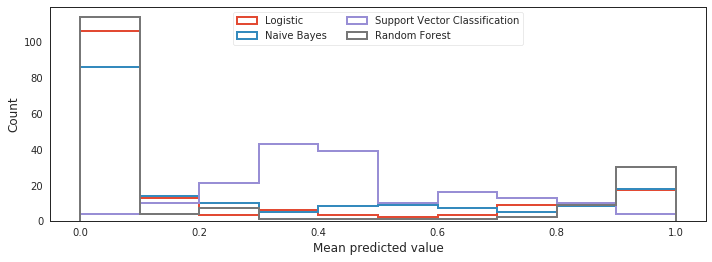

In [12]:
compare_alg("bus")

In this Class Random Forest has achieved excellent accuracy of 0.994. But we also notice that this classifier is not quite sure of its prediction as most of the prediction probability lies between 0 and 0.1.

## Class opel

Total no of opel 212
Acuracy with: Logistic 0.7647058823529411
Acuracy with: Naive Bayes 0.6705882352941176
Acuracy with: Support Vector Classification 0.7705882352941177
Acuracy with: Random Forest 0.7705882352941177


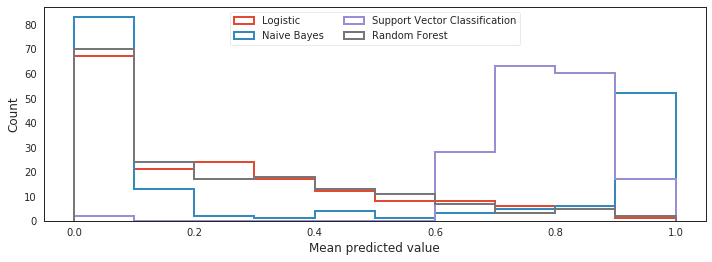

In [13]:
compare_alg("opel")

None of the classifiers have very good accuracy, it ranges from 0.67 to 0.77. SVC has the highest accuracy and is somewhat confident too.

Till now, we have treated the dataset equivalent to a dataset having binary classes and have used binary classifiers accordingly. The main aim behind this was not to find the classifer having best accuracy but to study the classifiers on the basis of their prediction probability. Now, let us use a different approach to study the same issue.

# Feature Importance

Now we will find out the most important parameters (just for the ease of visualisaton) and we will visualise what will be the prediction probability of various classifiers for a range of features. We will also plot the actual training data points having the same class.

Feature ranking:


,Feature,Importance
5,MAX.LENGTH_ASPECT_RATIO,0.183420
11,SCALED_VARIANCE_MINOR,0.123501
7,ELONGATEDNESS,0.117470
9,MAX.LENGTH_RECTANGULARITY,0.072566
0,COMPACTNESS,0.060507
2,DISTANCE_CIRCULARITY,0.047041
10,SCALED_VARIANCE_MAJOR,0.046713
14,SKEWNESS_ABOUT_MINOR,0.045462
17,HOLLOWS_RATIO,0.045071
15,KURTOSIS_ABOUT_MAJOR,0.043350


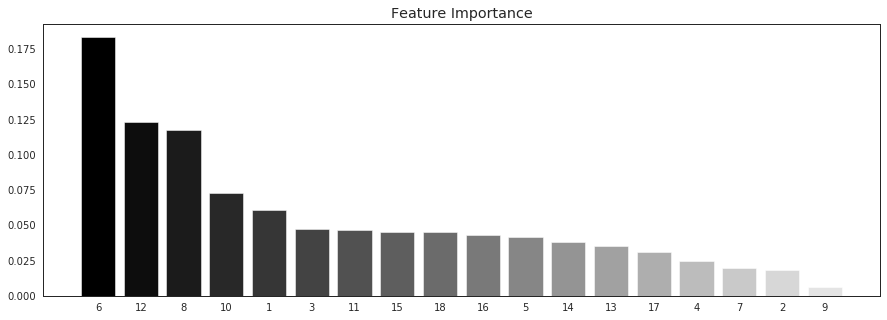

In [14]:
label=LabelEncoder()
df.Class= label.fit_transform(df.Class)



X = df.drop(labels='Class', axis=1)  # Drop the target attribute from the X variable
y = df.Class

    
train_X, test_X, train_y, test_y = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

features = train_X.columns.values

forest = ensemble.RandomForestClassifier(n_estimators=1000, max_features=18,
                                random_state=0)

forest.fit(train_X, train_y)
importances = forest.feature_importances_

df2 =  pd.DataFrame()

df2['Feature']= features
df2['Importance']= importances



indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 18
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  

plt.figure(figsize=(15,5))
plt.title(u"Feature Importance")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
               color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
df2.sort_values(by=['Importance'], ascending=False)

These results show that the feature "MAX.LENGTH_ASPECT_RATIO" and feature "SCALED_VARIANCE_MINOR" are the most important ones.

Note: The feature index starts from 1 here.

# Visualisation of prediction probability

We train the dataset using only the two most important features so that we can visualise prediction probabilities easily. 

### Classifiers used

Since it was found that logistic regression and Random forest classifier had more confidence in their predictions, therefore we are using them again. To further explore Logistic Regression we train three classifiers namely:
1. L1 logistic- Here penalty is set to 'l1'
2. L2 logistic (Multinomial) - Here penalty is set to 'l2'
3. L2 logistic (OvR)- Here multi_class='ovr'

Though the confidence of SVC was okay but still the accuracy was good for all the classes. Hence we wish to explore this classifier further.

Another Classifier we are using is Gaussian Process Classifier because the prediction is probabilistic (Gaussian) so that one can compute empirical confidence intervals and decide based on those if one should refit (online fitting, adaptive fitting) the prediction in some region of interest.

Random Forest Classifier had very good accuracies, also the prediction probabilities of this classifier showed that it is quite sure about its prediction. It would be interesting to study this Classifier further.

**Since we are using just two features, we don't go for test accuracy but go for training accuracy which will be interesting by itself**.

Accuracy (train) for L1 logistic: 62.6% 
Accuracy (train) for L2 logistic (Multinomial): 62.6% 
Accuracy (train) for L2 logistic (OvR): 62.1% 
Accuracy (train) for Linear SVC: 61.8% 
Accuracy (train) for GPC: 70.0% 
Accuracy (train) for Random Forest: 93.4% 


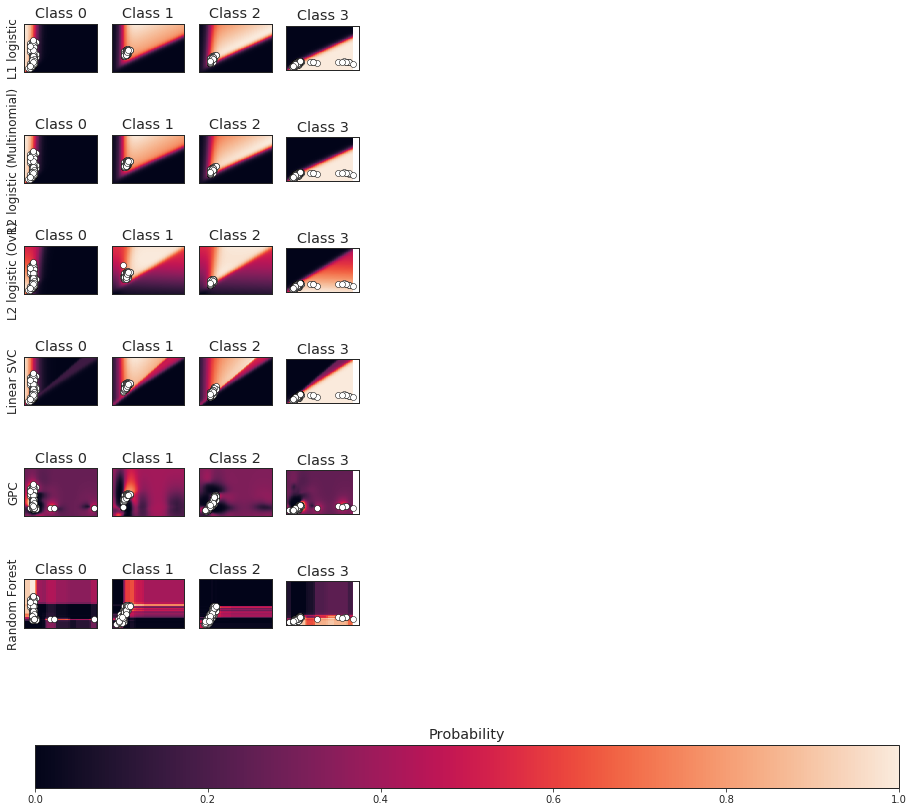

In [15]:
# Selecting the two most important features
X = df[["MAX.LENGTH_ASPECT_RATIO", "SCALED_VARIANCE_MINOR"]]
# Normalizing the data
X = (X - X.mean())/X.std()
# we only take the first two features for visualization
label=LabelEncoder()
df.Class= label.fit_transform(df.Class)
y = df.Class


n_features = X.shape[1]

C = 10
kernel = 1.0 * RBF([1.0, 1.0])  # for GPC

# Create different classifiers.
classifiers = {
    'L1 logistic':linear_model.LogisticRegression(C=C, penalty='l1',
                                      solver='saga',
                                      multi_class='multinomial',
                                      max_iter=10000),
    'L2 logistic (Multinomial)': linear_model.LogisticRegression(C=C, penalty='l2',
                                                    solver='saga',
                                                    multi_class='multinomial',
                                                    max_iter=10000),
    'L2 logistic (OvR)': linear_model.LogisticRegression(C=C, penalty='l2',
                                            solver='saga',
                                            multi_class='ovr',
                                            max_iter=10000),
    'Linear SVC':svm.SVC(kernel='linear', C=C, probability=True,
                      random_state=0),
    'GPC': GaussianProcessClassifier(kernel),
    'Random Forest': ensemble.RandomForestClassifier()
}

n_classifiers = len(classifiers)


plt.figure(figsize=(3 * 2, n_classifiers * 2))
plt.subplots_adjust(bottom=.2, top=.95)


xx = np.linspace(-2,10,100)
yy = np.linspace(-2,6,100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X, y)

    y_pred = classifier.predict(X)
    label=LabelEncoder()
    y_pred= label.fit_transform(y_pred)
    accuracy = accuracy_score(y, y_pred)
    print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))

    # View probabilities:
    probas = classifier.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size
    for k in range(n_classes):
        plt.subplot(n_classifiers, n_classes, index * n_classes + k + 1)
        plt.title("Class %d" % k)
        if k == 0:
            plt.ylabel(name)
        imshow_handle = plt.imshow(probas[:, k].reshape((100, 100)),
                                   extent=(-2,10,-2,6), origin='lower')
        plt.xticks(())
        plt.yticks(())
        X3 = X[["MAX.LENGTH_ASPECT_RATIO"]].T
        X4 = X[["SCALED_VARIANCE_MINOR"]].T
        X1 =[]
        X2 =[]
        idx = (y_pred == k)
        for i in range(len(idx)):
            if idx[i]== True:
                X1.append(X3[i])
                X2.append(X4[i])
        plt.scatter(X1,X2, marker='o', c='w', edgecolor='k')

       
ax = plt.axes([0.15, 0.04, 2, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

plt.show()

# Study misclassification

Now let us study the misclassification of various classifiers using confusion matrix. Here we use confusion matrix because it allows the visualisation of the performance of an algorithm. We have also used normalised confusion matrix to specifically intrepret which class is being misclassified.

## Confusion matrix

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
def confusion_matrix(classifier):
    classifier.fit(train_X, train_y)

    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(classifier, test_X, test_y,
                                     #display_labels=class_names,
                                     cmap=plt.cm.Blues_r,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()

### Random Forest Classifier

Confusion matrix, without normalization
[[44  0  0  0]
 [ 1 19 20  2]
 [ 3 17 23  1]
 [ 0  0  1 39]]
Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.02 0.45 0.48 0.05]
 [0.07 0.39 0.52 0.02]
 [0.   0.   0.03 0.97]]


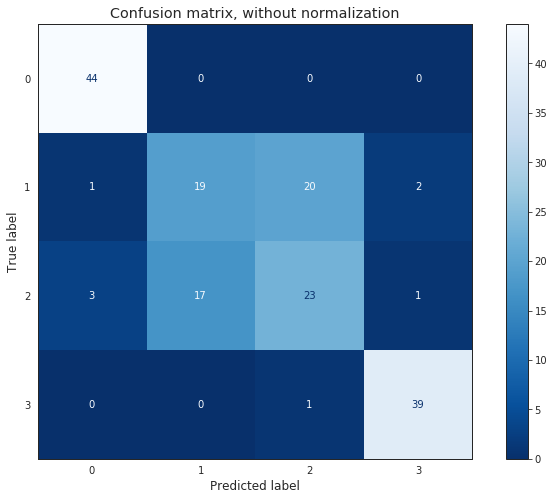

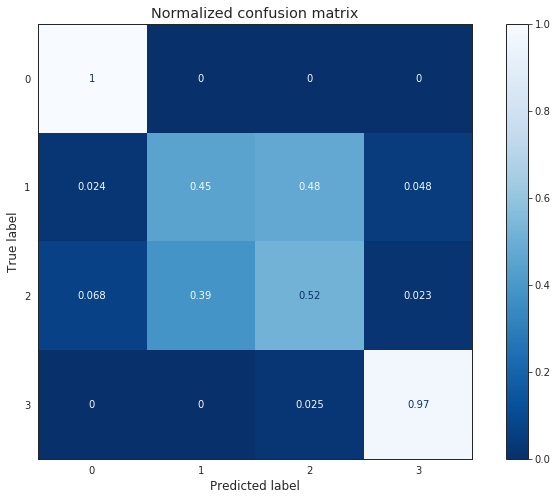

In [17]:
confusion_matrix(ensemble.RandomForestClassifier())

### Logistic Regression

Confusion matrix, without normalization
[[44  0  0  0]
 [ 2 24 15  1]
 [ 1  8 34  1]
 [ 0  0  2 38]]
Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.05 0.57 0.36 0.02]
 [0.02 0.18 0.77 0.02]
 [0.   0.   0.05 0.95]]


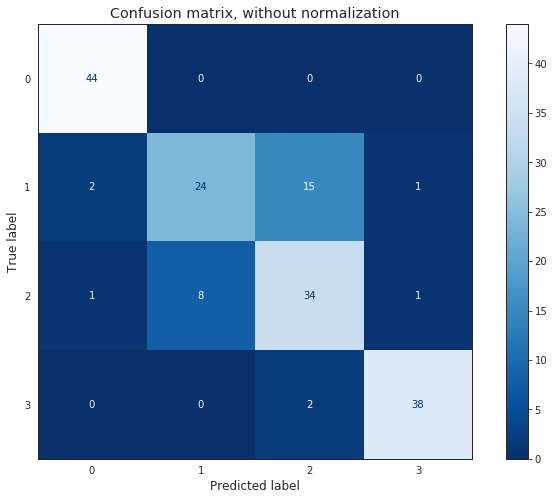

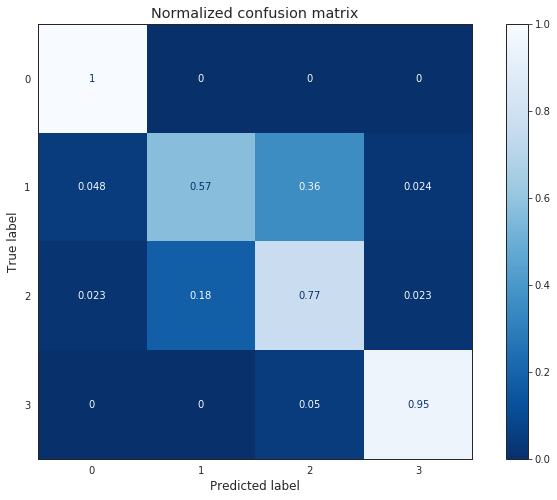

In [18]:
confusion_matrix(linear_model.LogisticRegression(penalty='l1',
                                          solver='saga',
                                          multi_class='multinomial',
                                          max_iter=10000))

### SVC

Confusion matrix, without normalization
[[44  0  0  0]
 [ 1 28 11  2]
 [ 4  8 32  0]
 [ 0  2  2 36]]
Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.02 0.67 0.26 0.05]
 [0.09 0.18 0.73 0.  ]
 [0.   0.05 0.05 0.9 ]]


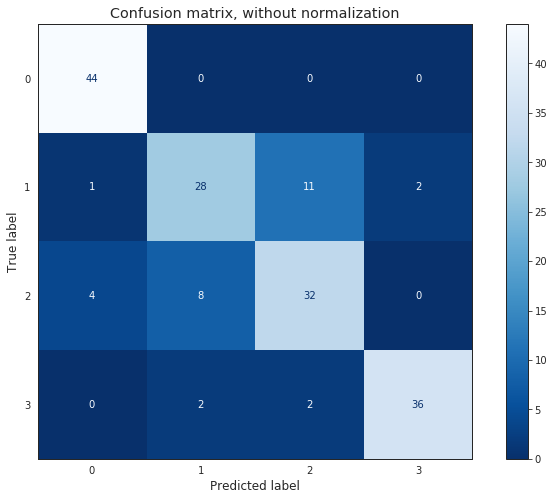

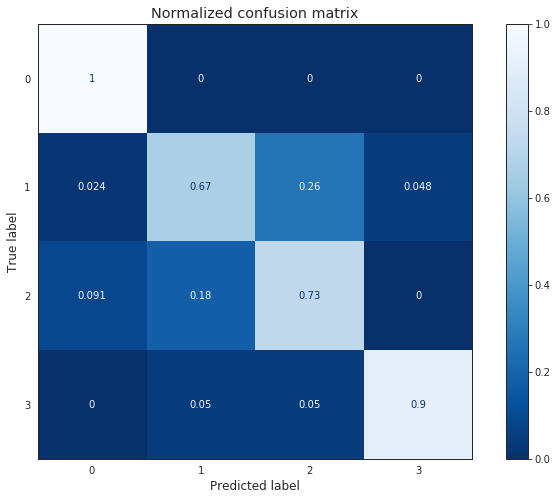

In [19]:
confusion_matrix(svm.SVC(kernel='linear', C=4,
                          random_state=0))

## Observation
There are a no. of things that we could observe from this visualisation (accuracy here is train accuracy):
1. Random Forset Classifier has the best accuracy of 93.4% (training), which is quite good considering the fact that we have used  only two features to train it. This accuracy is much higher than the accuracy of other classifiers which gives us an insight that Random forset classifier can fit well.
2. Three types of logistic regression classifiers were used. l1 and l2 have more or less the same behaviour in prediction probability as well as accuracy, when the multi_class parameter of the classifier was changed to "ovr" the prediction accuracy becomes less, which is shown visually by the change in colour. The accuracy of l2 logistic ovr remains almost the same as that of the other two.
3. Linear SVC doesn't show very good accuracy. We also observe that the prediction accuracy of this classifier changes slowly, for every class the prediction accuracy is not towards the extreme but is in the middle range.
4. For GPC we observe that the accuracy is second best next to random forest classifier (though the difference is huge) The figures corresponding to this classifier are also very different.

## Interpretation

This was a very interesting issue and I learned a lot from this about a very important aspect of the classifier that is its prediction probability. This exploration also helps in choosing the classifier based upon their confidence of prediction.

1. Random Forest Classifer has very good accuracy for all the cases observed. The more important thing is that it is quite confident about its predictions.

2. If a model is to be selected based upon their confidence level about prediction then logistic regression is better then the GPC or SVC.

3. Logistic Regression should also be preffered during model selection if misclassifications are considered.